In [1]:
import hydra
from glob import  glob
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from proteoscope.data import ProteoscopeDM
from proteoscope.modules import CytoselfLM, AutoencoderLM, ProteoscopeLM


test = 'proteoscope' # proteoscope autoencoder

# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-18-31" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-22/07-24-27" # Best proteoscope - ESM-mean
BASE_DIR = f"/home/ec2-user/outputs/proteoscope/2023-08-25/05-54-50" # Best proteoscope - ESM-full
# BASE_DIR = f"/home/ec2-user/outputs/autoencoder/2023-08-19/17-28-45" # Best autoencoder

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1] #-1
    print('   Using ', chkpt)

    pdm = ProteoscopeDM(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        trim=config.data.trim,
        sequence_embedding=config.data.sequence_embedding,
        splits=config.splits,
    )
    pdm.setup()

    if test == 'autoencoder':
        alm = AutoencoderLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        alm.vae.to('cuda')
        alm.eval()
    elif test == 'proteoscope':
        plm = ProteoscopeLM.load_from_checkpoint(
            chkpt,
            module_config=config.module,
            strict=False,
        )

        plm.unet.eval()
        plm.unet.cuda()

        plm.autoencoder.cuda()
        plm.cytoself.cuda()
    else:
        raise ValueError(f"Unrecognized option {test}")

# BASE_DIR = "/home/ec2-user/outputs/cytoself/2023-08-21/19-45-50" # Best cytoself all proteins
# # BASE_DIR = "/home/ec2-user/outputs/cytoself/2023-08-03/05-45-38" # Best cytoself train proteins
# protein_split = 'all_' # '' or 'all_'
# num_class = 1311 # 1049 or 1311
# config_dir = BASE_DIR + "/.hydra"

# with hydra.initialize_config_dir(config_dir=config_dir):
#     config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

#     chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
#     chkpts.sort()
#     chkpt = chkpts[-1]
#     print('   Using ', chkpt)

#     clm = CytoselfLM.load_from_checkpoint(
#         chkpt,
#         module_config=config.module,
#         num_class=num_class,
#     )

#     clm.model.to('cuda')
#     clm.model.eval()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_8211/575370744.py:20: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoscope/2023-08-25/05-54-50/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/data/datamodule.py:41: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


## Reconstruct val images

In [2]:
# dl = pdm.val_dataloader()
dl = pdm.custom_dataloader(split_images='val', split_protein='val', shuffle=True)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
import torch
from tqdm import tqdm
import numpy as np
from piqa import SSIM, PSNR
from torchmetrics.image.fid import FrechetInceptionDistance


ssim = SSIM(n_channels=1).to('cuda')
psnr = PSNR().to('cuda')
fid_pro = FrechetInceptionDistance(normalize=True).to('cuda')
fid_nuc = FrechetInceptionDistance(normalize=True).to('cuda')

index = []
input_images = []
output_images = []
input_cytoself_embeds = []
output_cytoself_embeds = []
input_autoencoder_embeds = []
input_cytoself_logits = []
output_cytoself_logits = []
diffused_autoencoder_embeds = []

ssim_scores_pro = []
ssim_scores_nuc = []
psnr_scores_pro = []
psnr_scores_nuc = []

with torch.no_grad():
    for batch in tqdm(dl):
        batch['image'] = batch['image'].to('cuda')
        
        input_image = batch['image']
        input_cytoself_embed = plm.cytoself(input_image, 'vqvec2')
        _, input_cytoself_logit = plm.cytoself(input_image)

        if test == 'autoencoder':
            output_image, _, input_autoencoder_embed = alm(input_image, return_embed=True, sample_posterior=False)
            diffused_autoencoder_embed = torch.empty(0)
        elif test == 'proteoscope':
            diffused_autoencoder_embed = plm.sample(batch, guidance_scale=3.0, cond_images=None, num_inference_steps=200)
            output_image = plm.autoencoder.decode(diffused_autoencoder_embed).sample
            input_autoencoder_embed = plm.autoencoder.encode(batch['image']).latent_dist.mean

        output_image = output_image.clip(0, 1)
        output_cytoself_embed = plm.cytoself(output_image, 'vqvec2')
        _, output_cytoself_logit = plm.cytoself(output_image)

        ssim_pro = ssim(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        ssim_nuc = ssim(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        psnr_pro = psnr(input_image[:, 0].unsqueeze_(1), torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1))
        psnr_nuc = psnr(input_image[:, 1].unsqueeze_(1), torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1))

        fid_pro.update(input_image[:, 0].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_pro.update(torch.clip(output_image[:, 0].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        fid_nuc.update(input_image[:, 1].unsqueeze_(1).tile(1, 3, 1, 1), real=True)
        fid_nuc.update(torch.clip(output_image[:, 1].unsqueeze_(1), 0, 1).tile(1, 3, 1, 1), real=False)

        index.append(batch['index'].detach().cpu().numpy())
        ssim_scores_pro.append([ssim_pro.detach().cpu().numpy()])
        ssim_scores_nuc.append([ssim_nuc.detach().cpu().numpy()])
        psnr_scores_pro.append([psnr_pro.detach().cpu().numpy()])
        psnr_scores_nuc.append([psnr_nuc.detach().cpu().numpy()])
        input_images.append(input_image.detach().cpu().numpy())
        output_images.append(output_image.detach().cpu().numpy())
        input_cytoself_embeds.append(input_cytoself_embed.detach().cpu().numpy())
        output_cytoself_embeds.append(output_cytoself_embed.detach().cpu().numpy())
        input_autoencoder_embeds.append(input_autoencoder_embed.detach().cpu().numpy())
        input_cytoself_logits.append(input_cytoself_logit.detach().cpu().numpy())
        output_cytoself_logits.append(output_cytoself_logit.detach().cpu().numpy())
        diffused_autoencoder_embeds.append(diffused_autoencoder_embed.detach().cpu().numpy())

  0%|          | 0/664 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/664 [00:37<6:49:28, 37.06s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 2/664 [01:04<5:48:16, 31.57s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 3/664 [01:32<5:28:17, 29.80s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 4/664 [02:00<5:18:50, 28.99s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 5/664 [02:27<5:13:24, 28.53s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 6/664 [02:55<5:09:55, 28.26s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 7/664 [03:23<5:07:53, 28.12s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 8/664 [03:51<5:06:25, 28.03s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|▏         | 9/664 [04:19<5:05:00, 27.94s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 10/664 [04:46<5:03:51, 27.88s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 11/664 [05:14<5:03:00, 27.84s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 12/664 [05:42<5:02:12, 27.81s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 13/664 [06:10<5:01:26, 27.78s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 14/664 [06:37<5:00:57, 27.78s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 15/664 [07:05<5:00:30, 27.78s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 16/664 [07:33<5:00:05, 27.79s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 17/664 [08:01<4:59:37, 27.79s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 18/664 [08:28<4:59:03, 27.78s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 19/664 [08:56<4:58:32, 27.77s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 20/664 [09:24<4:57:55, 27.76s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 21/664 [09:52<4:57:34, 27.77s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 22/664 [10:19<4:57:07, 27.77s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  3%|▎         | 23/664 [10:47<4:57:12, 27.82s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▎         | 24/664 [11:15<4:56:34, 27.80s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 25/664 [11:43<4:56:08, 27.81s/it]

  0%|          | 0/200 [00:00<?, ?it/s]

  4%|▍         | 25/664 [11:55<5:04:48, 28.62s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:40                                                                                   │
│                                                                                                  │
│   37 │   │   │   output_image, _, input_autoencoder_embed = alm(input_image, return_embed=Tru    │
│   38 │   │   │   diffused_autoencoder_embed = torch.empty(0)                                     │
│   39 │   │   elif test == 'proteoscope':                                                         │
│ ❱ 40 │   │   │   diffused_autoencoder_embed = plm.sample(batch, guidance_scale=3.0, cond_imag    │
│   41 │   │   │   output_image = plm.autoencoder.decode(diffused_autoencoder_embed).sample        │
│   42 │   │   │   input_autoencoder_embed = plm.autoencoder.encode(batch['image']).latent_dist    │
│   43                                                                                             │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/modules/proteoscope.py:296 in sample                      │
│                                                                                                  │
│   293 │   │   │                                                                                  │
│   294 │   │   │   # predict the noise residual                                                   │
│   295 │   │   │   with torch.no_grad():                                                          │
│ ❱ 296 │   │   │   │   noise_pred = self.unet(                                                    │
│   297 │   │   │   │   │   latent_model_input,                                                    │
│   298 │   │   │   │   │   t,                                                                     │
│   299 │   │   │   │   │   encoder_hidden_states=seq_embeds,                                      │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1190 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:905 in │
│ forward                                                                                          │
│                                                                                                  │
│   902 │   │   down_block_res_samples = (sample,)                                                 │
│   903 │   │   for downsample_block in self.down_blocks:                                          │
│   904 │   │   │   if hasattr(downsample_block, "has_cross_attention") and downsample_block.has   │
│ ❱ 905 │   │   │   │   sample, res_samples = downsample_block(                                    │
│   906 │   │   │   │   │   hidden_states=sample,            

In [4]:
fid_pro_score = fid_pro.compute()
fid_nuc_score = fid_nuc.compute()

In [5]:
index = np.concatenate(index, axis=0)
ssim_scores_pro = np.concatenate(ssim_scores_pro, axis=0)
ssim_scores_nuc = np.concatenate(ssim_scores_nuc, axis=0)
psnr_scores_pro = np.concatenate(psnr_scores_pro, axis=0)
psnr_scores_nuc = np.concatenate(psnr_scores_nuc, axis=0)

In [6]:
input_images = np.concatenate(input_images, axis=0)
output_images = np.concatenate(output_images, axis=0)
input_cytoself_embeds = np.concatenate(input_cytoself_embeds, axis=0)
input_autoencoder_embeds = np.concatenate(input_autoencoder_embeds, axis=0)
diffused_autoencoder_embeds = np.concatenate(diffused_autoencoder_embeds, axis=0)

In [7]:
input_cytoself_logits = np.concatenate(input_cytoself_logits, axis=0)
output_cytoself_logits = np.concatenate(output_cytoself_logits, axis=0)
output_cytoself_embeds = np.concatenate(output_cytoself_embeds, axis=0)

In [8]:
# tmp_path = '/home/ec2-user/cytoself-data/tmp/full'

# np.save(f'{tmp_path}/index.npy', index)
# np.save(f'{tmp_path}/ssim_scores_pro.npy', ssim_scores_pro)
# np.save(f'{tmp_path}/ssim_scores_nuc.npy', ssim_scores_nuc)
# np.save(f'{tmp_path}/psnr_scores_pro.npy', psnr_scores_pro)
# np.save(f'{tmp_path}/psnr_scores_nuc.npy', psnr_scores_nuc)


# np.save(f'{tmp_path}/input_images.npy', input_images)
# np.save(f'{tmp_path}/output_images.npy', output_images)
# np.save(f'{tmp_path}/input_cytoself_embeds.npy', input_cytoself_embeds)
# np.save(f'{tmp_path}/input_autoencoder_embeds.npy', input_autoencoder_embeds)
# np.save(f'{tmp_path}/diffused_autoencoder_embeds.npy', diffused_autoencoder_embeds)

# np.save(f'{tmp_path}/input_cytoself_logits.npy', input_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_logits.npy', output_cytoself_logits)
# np.save(f'{tmp_path}/output_cytoself_embeds.npy', output_cytoself_embeds)

In [9]:
# index = np.load(f'{tmp_path}/index.npy')
# ssim_scores_pro = np.load(f'{tmp_path}/ssim_scores_pro.npy')
# ssim_scores_nuc = np.load(f'{tmp_path}/ssim_scores_nuc.npy')
# psnr_scores_pro = np.load(f'{tmp_path}/psnr_scores_pro.npy')
# psnr_scores_nuc = np.load(f'{tmp_path}/psnr_scores_nuc.npy')


# input_images = np.load(f'{tmp_path}/input_images.npy')
# output_images = np.load(f'{tmp_path}/output_images.npy')
# input_cytoself_embeds = np.load(f'{tmp_path}/input_cytoself_embeds.npy')
# input_autoencoder_embeds = np.load(f'{tmp_path}/input_autoencoder_embeds.npy')
# diffused_autoencoder_embeds = np.load(f'{tmp_path}/diffused_autoencoder_embeds.npy')

# input_cytoself_logits = np.load(f'{tmp_path}/input_cytoself_logits.npy')
# output_cytoself_logits = np.load(f'{tmp_path}/output_cytoself_logits.npy')
# output_cytoself_embeds = np.load(f'{tmp_path}/output_cytoself_embeds.npy')

In [10]:
print(len(input_images))

400


In [11]:
true_names = np.array(pdm.labels['name'])[index]
true_localizations = np.array(pdm.labels['localization'])[index]
true_labels = np.array(pdm.labels['label'])[index]

In [12]:
np.mean(input_autoencoder_embeds)

0.06132954

In [13]:
np.std(input_autoencoder_embeds)

2.8959196

In [14]:
print(input_autoencoder_embeds.max())
print(input_autoencoder_embeds.min())

8.472054
-7.949044


In [15]:
print(fid_pro_score)
print(fid_nuc_score)

tensor(70.8733, device='cuda:0')
tensor(24.2101, device='cuda:0')


In [16]:
print(ssim_scores_pro.mean())
print(ssim_scores_nuc.mean())

0.46665454
0.53066653


In [17]:
print(psnr_scores_pro.mean())
print(psnr_scores_nuc.mean())

21.909458
19.450768


In [18]:
input_cytoself_labels = input_cytoself_logits.argmax(axis=1)
output_cytoself_labels = output_cytoself_logits.argmax(axis=1)

Accuracy 0.5775


/tmp/ipykernel_8211/3474189015.py:13: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


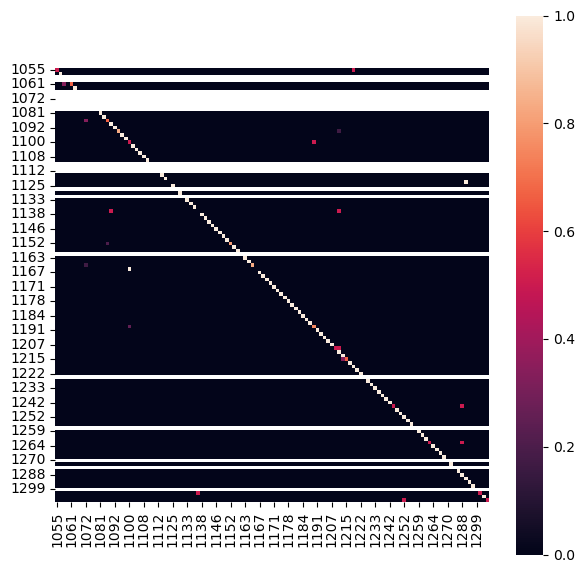

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(true_labels)
# class_labels = range(num_class)

acc = accuracy_score(true_labels, input_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, input_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

Accuracy 0.01


/tmp/ipykernel_8211/2910221747.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm / cm.sum(axis=1)[:, None]


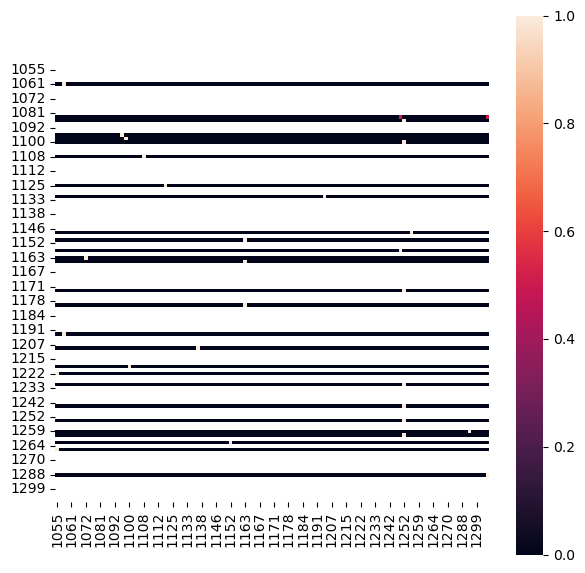

In [46]:
acc = accuracy_score(true_labels, output_cytoself_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, output_cytoself_labels, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=False, fmt=".2f");

In [21]:
def top_k_accuracy(y_true, y_score, k=5):
    # Get the indices of the top k predicted classes for each sample
    top_k_preds = np.argsort(y_score, axis=1)[:, -k:]
    
    # Check if the true class is among the top k for each sample
    correct = np.any(top_k_preds == y_true[:, np.newaxis], axis=1)

    # Calculate the mean accuracy
    top_k_acc = np.mean(correct)
    
    return top_k_acc

In [22]:
input_classification_scores = [top_k_accuracy(true_labels, input_cytoself_logits, k=k) for k in range(1, 20)]

In [23]:
output_classification_scores = [top_k_accuracy(true_labels, output_cytoself_logits, k=k) for k in range(1, 20)]

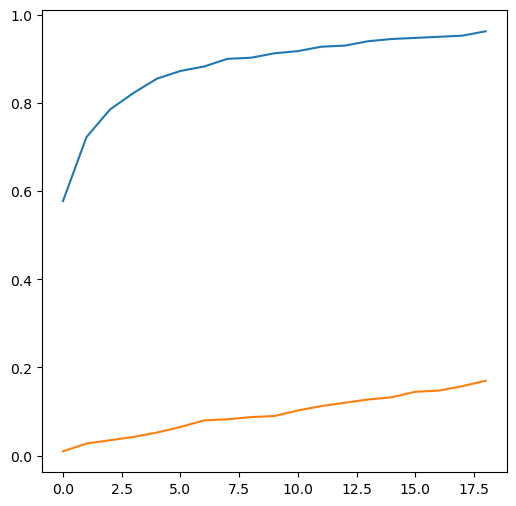

In [24]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores);
plt.plot(output_classification_scores);

In [25]:
print(input_classification_scores[9])
print(output_classification_scores[9])

0.9125
0.09


In [26]:
import numpy as np
from collections import defaultdict
from scipy.special import softmax


def average_rows(arr, M):
    N = arr.shape[0]

    if M > N:
        raise ValueError("M must be less than or equal to N")

    # Create a random permutation of the rows
    permuted_indices = np.random.permutation(N)[: (N // M) * M]

    # Reshape the permuted indices to create groups of M rows
    groups_of_M = permuted_indices.reshape(N // M, M)

    # Average each group to produce N/M averages of M rows
    averaged_rows = [np.mean(arr[group], axis=0) for group in groups_of_M]

    return np.array(averaged_rows)


def average_logits_prediction(labels, logits, M):
    logits_by_label = defaultdict(list)
    for logit, label in zip(logits, labels):
        logits_by_label[label].append(logit)

    n_pred = 0
    sum_pred = 0
    for key, logits in logits_by_label.items():
        # logits = softmax(logits, axis=1)
        if M <= len(logits):
            averaged_predictions = average_rows(np.array(logits), M).argmax(axis=1)
            sum_pred = sum_pred + (averaged_predictions == key).sum()
            n_pred = n_pred + len(averaged_predictions)

    return sum_pred / n_pred

In [27]:
input_classification_scores_avg = [average_logits_prediction(true_labels, input_cytoself_logits, M=k) for k in range(1, 4)]

In [28]:
output_classification_scores_avg = [average_logits_prediction(true_labels, output_cytoself_logits, M=k) for k in range(1, 4)]

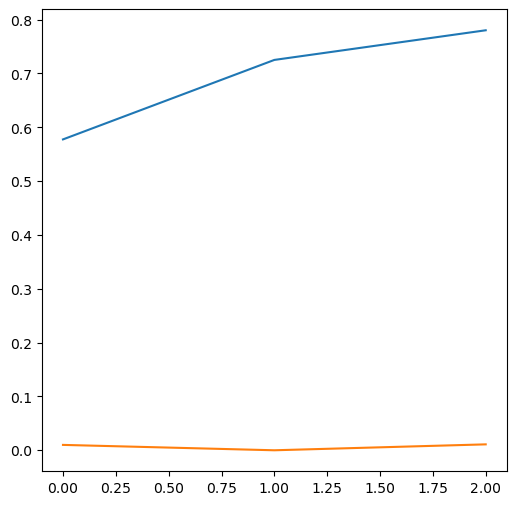

In [29]:
plt.figure(figsize=(6, 6));
plt.plot(input_classification_scores_avg);
plt.plot(output_classification_scores_avg);

In [30]:
print(input_classification_scores_avg[5])
print(output_classification_scores_avg[5])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 print(input_classification_scores_avg[5])                                                    │
│   2 print(output_classification_scores_avg[5])                                                   │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [81]:
print((true_labels == input_cytoself_logits.argmax(axis=1)).mean())
print((true_labels == output_cytoself_logits.argmax(axis=1)).mean())

0.5775
0.01


In [82]:
def cross_entropy_loss(y_true, logits, eps=1e-20):
    # Compute the softmax activation
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    softmax_probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

    # Gather the probabilities corresponding to the true labels
    true_probs = softmax_probs[np.arange(len(y_true)), y_true]

    # Compute the cross-entropy loss
    loss = -np.mean(np.log(true_probs + eps))

    return loss

In [80]:
print(cross_entropy_loss(true_labels, input_cytoself_logits))
print(cross_entropy_loss(true_labels, output_cytoself_logits))

1.5734777
16.567982


In [32]:
print(np.mean((input_cytoself_embeds - output_cytoself_embeds)**2))

0.68912023


In [85]:
batch['sequence_embed'].shape

torch.Size([16, 1024, 1280])

## Images

In [31]:
# FID ↓ IS ↑ PSNR ↑ SSIM ↑
# FCD, CS ....

In [32]:
from proteoscope.plotting import browse_reconstructions, merge_prot_nuc

In [33]:
browse_reconstructions(input_images[:, 0], output_images[:, 0], true_names)

interactive(children=(Dropdown(description='name', options=('AAMP', 'AATF', 'ABCE1', 'ACAP2', 'ACTB', 'ACTG1',…

## Merged nuclei view

In [34]:
true_merged = merge_prot_nuc(input_images[:1000], percentiles=[0.1, 99.9])
predicted_merged = merge_prot_nuc(output_images[:1000], percentiles=[0.1, 99.9])
true_names_merged = true_names[:1000]

In [35]:
browse_reconstructions(true_merged, predicted_merged, true_names_merged)

interactive(children=(Dropdown(description='name', options=('AAMP', 'AATF', 'ACAP2', 'ACTB', 'ACTN1', 'ACTN4',…

## Visualize in cytoself umap

In [36]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/results"

In [37]:
zarr_path = join(datapath, f"cytoself_{protein_split}embeddings_vqvec2.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
# localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
# names = np.load(join(datapath, "good_names_redo21.npy"))
# complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
# complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [38]:
if protein_split == '':
    labels = pdm.labels[np.logical_and(pdm.labels['split_images'] == 'val', pdm.labels['split_protein'] == 'train')]
else:
    labels = pdm.labels[pdm.labels['split_images'] == 'val']

names = np.array(labels['name'])
localizations = np.array(labels['localization'])
complexes = np.array(labels['complex'])
complexes_fig = np.array(labels['complex_fig'])

In [39]:
print(embeddings.max())
print(embeddings.min())

print(output_cytoself_embeds.max())
print(output_cytoself_embeds.min())

3.748565673828125
-0.24751652777194977
3.7485657
-0.24751651


In [40]:
from joblib import load

reducer = load(join(datapath, f'cytoself_{protein_split}umap_model.joblib'))

In [41]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [42]:
reduced_input_cytoself_embeds = reducer.transform(input_cytoself_embeds.reshape(input_cytoself_embeds.shape[0], -1))
reduced_output_cytoself_embeds = reducer.transform(output_cytoself_embeds.reshape(output_cytoself_embeds.shape[0], -1))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/llvmlite/ir/_utils.py:56 in get_reference    │
│                                                                                                  │
│   53 │                                                                                           │
│   54 │   def get_reference(self):                                                                │
│   55 │   │   try:                                                                                │
│ ❱ 56 │   │   │   return self.__cached_refstr                                                     │
│   57 │   │   except AttributeError:                                                              │
│   58 │   │   │   s = self.__cached_refstr = self._get_reference()                                │
│   59 │   │   │   return s                                                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Argument' object has no attribute '_StringReferenceCaching__cached_refstr'

During handling of the above exception, another exception occurred:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 reduced_input_cytoself_embeds = reducer.transform(input_cytoself_embeds.reshape(input_cy     │
│   2 reduced_output_cytoself_embeds = reducer.transform(output_cytoself_embeds.reshape(output     │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/umap/umap_.py:2958 in transform              │
│                                                                                                  │
│   2955 │   │   # )                                                                               │
│   2956 │   │                                                                                     │
│   2957 │   │   if self.output_metric == "euclidean":                                             │
│ ❱ 2958 │   │   │   embedding = optimize_layout_euclidean(                                        │
│   2959 │   │   │   │   embedding,                                                                │
│   2960 │   │   │   │   self.embedding_.astype(np.float32, copy=True),  # Fixes #179 & #217,      │
│   2961 │   │   │   │   head,                                                                     │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/umap/layouts.py:369 in                       │
│ optimize_layout_euclidean                                                                        │
│                                                                                                  │
│    366 │   │   │   dens_re_mean = 0                                                              │
│    367 │   │   │   dens_re_cov = 0                                                               │
│    368 │   │                                                                                     │
│ ❱  369 │   │   optimize_fn(                                                                      │
│    370 │   │   │   head_embedding,                                                               │
│    371 │   │   │   tail_embedding,                                                               │
│    372 │   │   │   head,                                                                         │


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

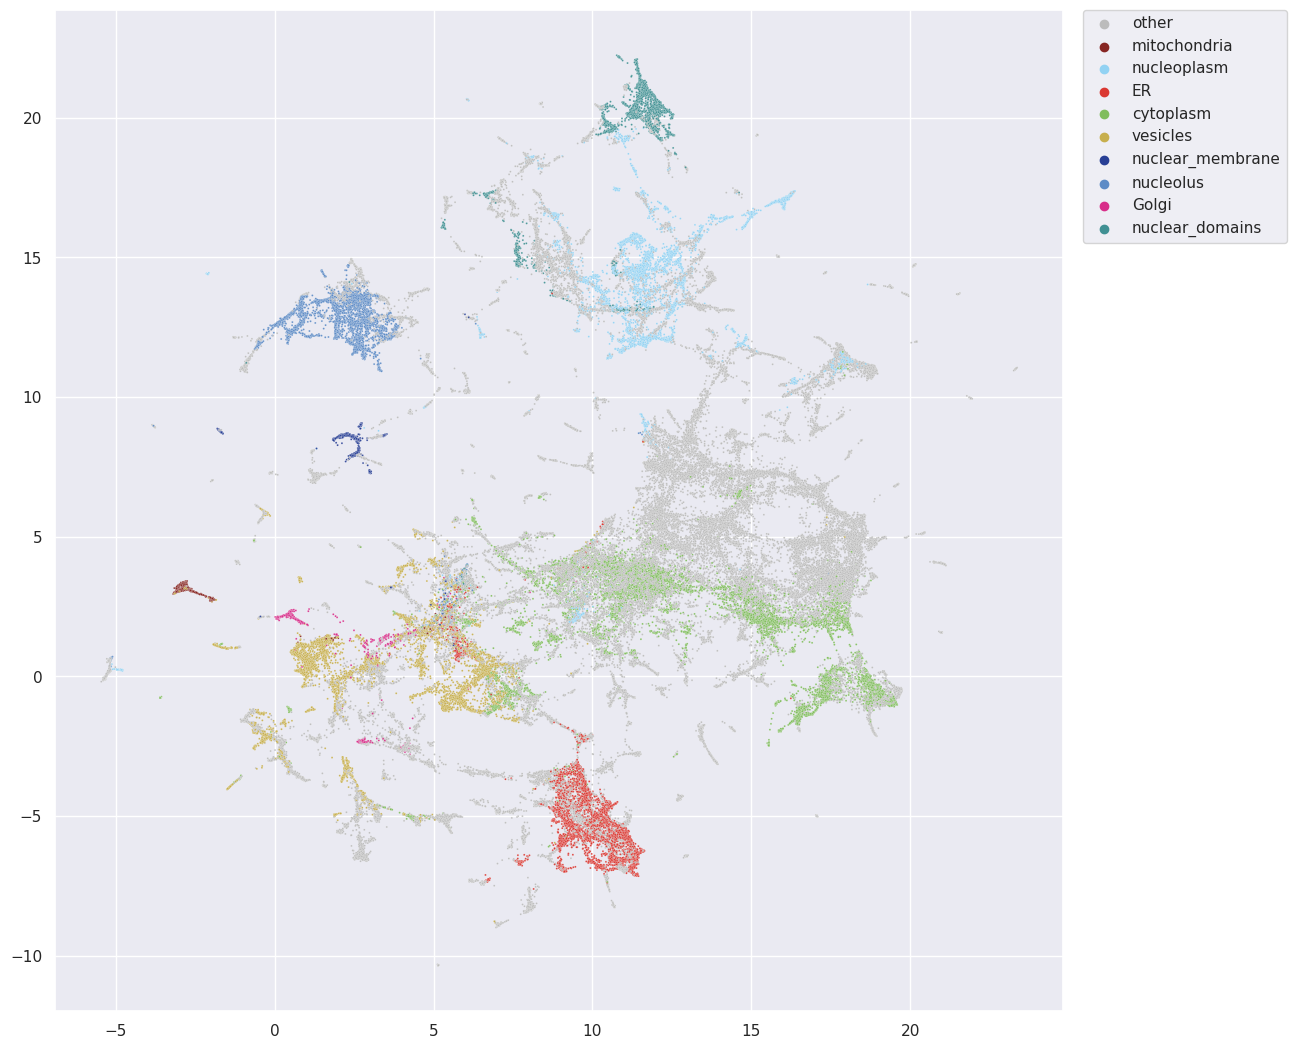

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

<AxesSubplot:>

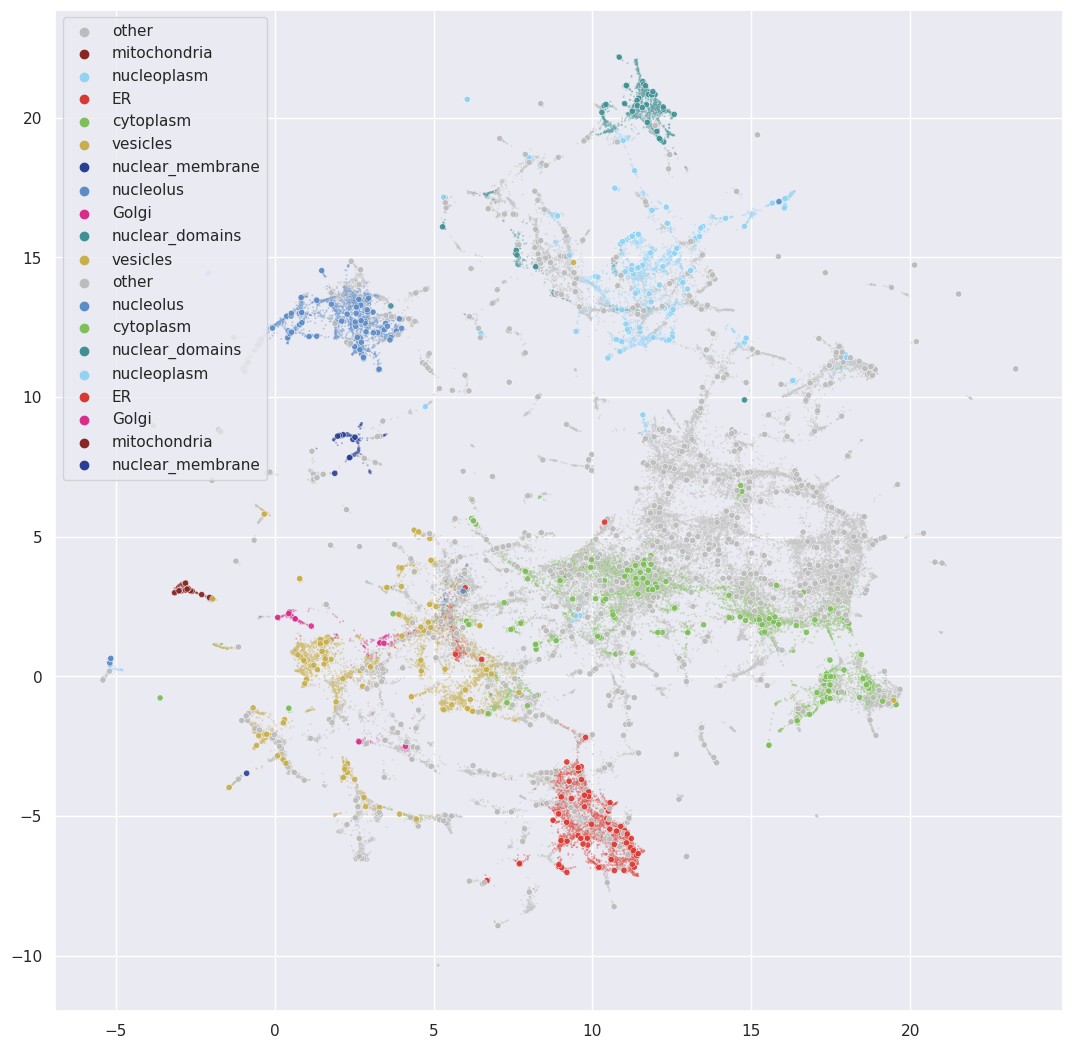

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_output_cytoself_embeds[:, 0], y=reduced_output_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)

<AxesSubplot:>

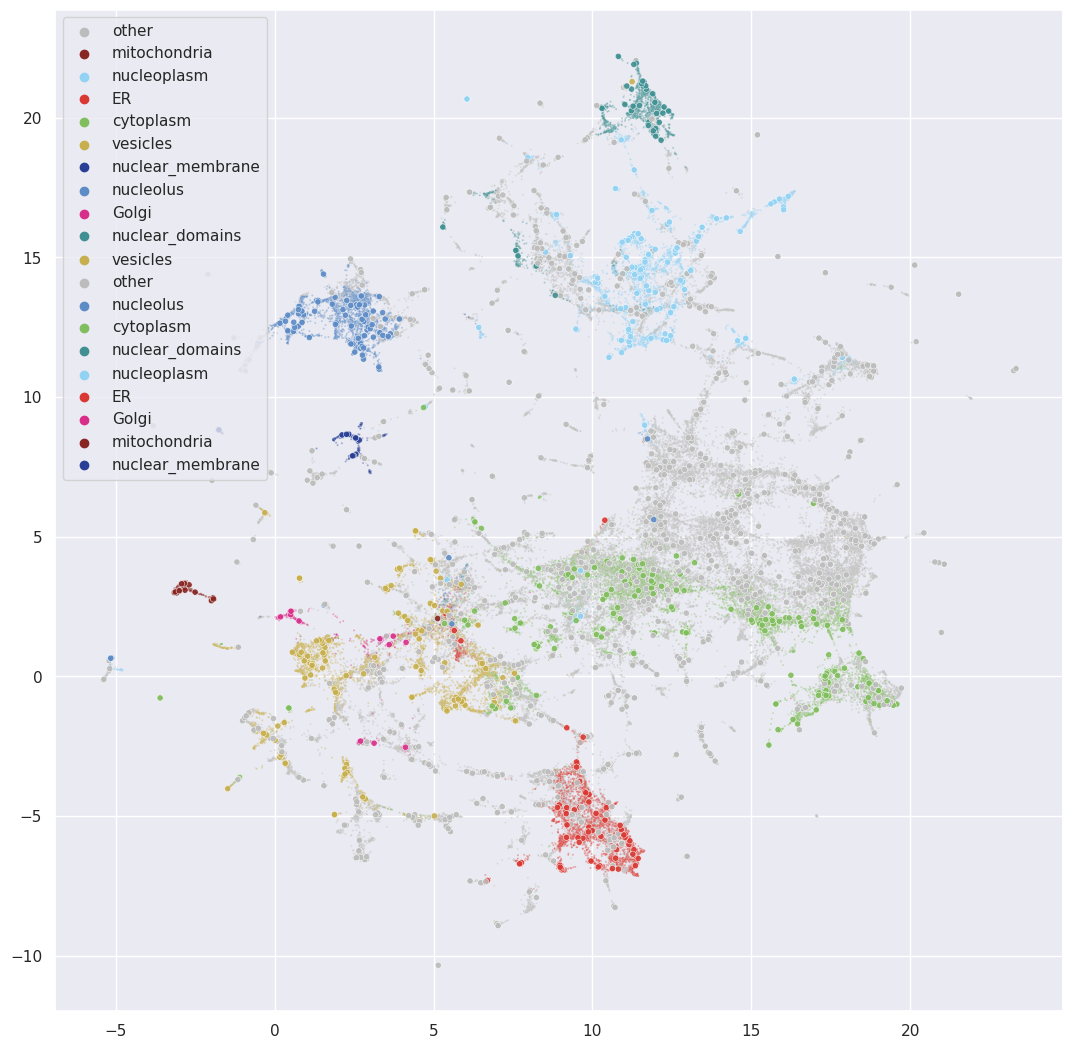

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_input_cytoself_embeds[:, 0], y=reduced_input_cytoself_embeds[:, 1], hue=true_localizations, s=20, alpha=0.9, palette=label_colors)

## FCD scores with cyostelf

In [ ]:
def compute_latent_statistics(latents, classes=None, all_classes=None):
    latents = latents.reshape(latents.shape[0], -1)

    if classes is None:
        latent_mean = np.mean(latents, axis=0)
        latent_cov = np.cov(latents, rowvar=False)
    else:
        if all_classes is None:
            all_classes = np.unique(classes)

        latent_mean = np.array([np.mean(latents[classes == c], axis=0) for c in all_classes])
        latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])

    return {'mean': latent_mean, 'cov': latent_cov, 'class': all_classes}

In [ ]:
from scipy.linalg import sqrtm


def frechet_distance(mu1, sigma1, mu2, sigma2):
    """
    Compute the Fréchet distance between two multivariate Gaussian distributions.
    """
    mean_diff = mu1 - mu2
    mean_diff_squared = mean_diff.dot(mean_diff)
    cov_mean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    trace_term = np.trace(sigma1 + sigma2 - 2 * cov_mean)
    frechet_dist = mean_diff_squared + trace_term
    return frechet_dist

In [ ]:
all_names = np.unique(true_names)
input_cytoself_stats = compute_latent_statistics(input_cytoself_embeds, true_names, all_names)
output_cytoself_stats = compute_latent_statistics(output_cytoself_embeds, true_names, all_names)

/tmp/ipykernel_20489/3089917380.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  latent_cov = np.array([np.cov(latents[classes == c], rowvar=False) for c in all_classes])


In [ ]:
# zipped = zip(input_cytoself_stats['mean'], input_cytoself_stats['cov'], output_cytoself_stats['mean'], output_cytoself_stats['cov'])
# fcd_scores = np.array([frechet_distance(mu1, sigma1, mu2, sigma2) for mu1, sigma1, mu2, sigma2 in zipped])

In [ ]:
# print(fcd_scores.mean())
# print(fcd_scores.std())

In [ ]:
input_cytoself_stats_all = compute_latent_statistics(input_cytoself_embeds, None, None)
output_cytoself_stats_all = compute_latent_statistics(output_cytoself_embeds, None, None)

In [ ]:
mu1, sigma1 = input_cytoself_stats_all['mean'], input_cytoself_stats_all['cov']
mu2, sigma2 = output_cytoself_stats_all['mean'], output_cytoself_stats_all['cov']
fcd_score_all = frechet_distance(mu1, sigma1, mu2, sigma2)
print(fcd_score_all)

27.558775425052435


## Medians

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Generate sample data
n = input_cytoself_stats['mean'].shape[0]
Set_A = input_cytoself_stats['mean'].copy()
Set_B = output_cytoself_stats['mean'].copy()

# Compute pairwise distances for given pairs
given_pair_dists = np.array([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Compute pairwise distances for random pairs (1000 times)
random_pair_dists = []
np.random.seed(0)
for _ in range(1000):
    np.random.shuffle(Set_B)
    random_pair_dists.extend([euclidean(Set_A[i], Set_B[i]) for i in range(n)])

# Statistical comparison
_, p_value = mannwhitneyu(given_pair_dists, random_pair_dists)
print(f"P-value: {p_value}")

P-value: 0.0


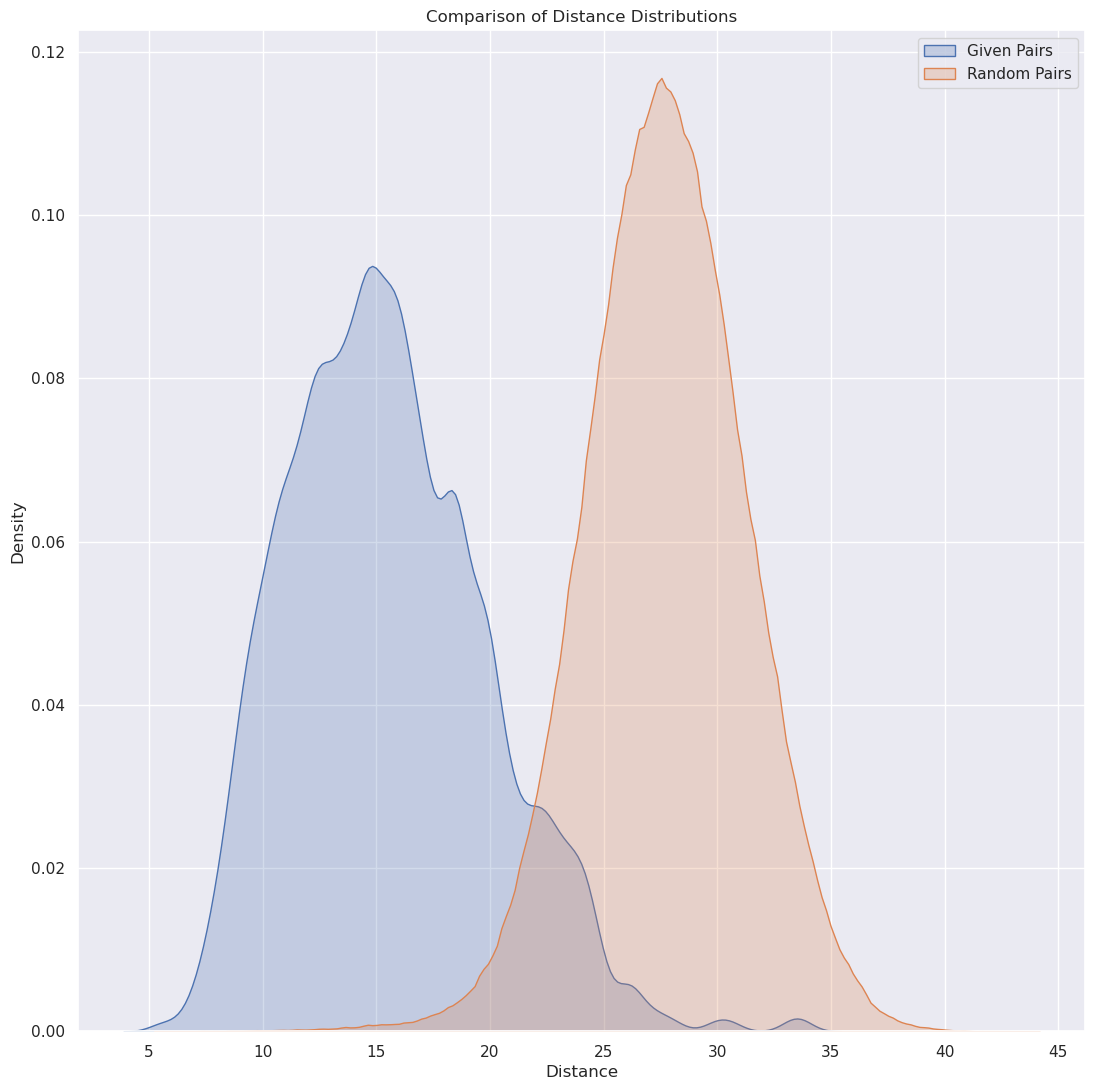

In [ ]:
# Visualization
sns.kdeplot(given_pair_dists, label="Given Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
sns.kdeplot(random_pair_dists, label="Random Pairs", shade=True, clip=(0, None), bw_adjust=0.5)
plt.legend()
plt.xlabel("Distance")
plt.ylabel("Density")
plt.title("Comparison of Distance Distributions")
plt.show()

In [ ]:
print(np.mean(given_pair_dists))
print(np.mean(random_pair_dists))

15.506216222226263
27.683139855124423


## Run localization classifier

In [ ]:
from joblib import load

# Load the model from the file
clf = load(join(datapath, f'cytoself_{protein_split}localization_classifier.joblib'))

In [ ]:
other = true_localizations == 'other'
X_test = input_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [ ]:
y_predict = clf.predict(X_test)

In [ ]:
y_predict_scores = clf.predict_proba(X_test)

In [ ]:
y_test_indices = np.searchsorted(clf.classes_, y_test)
input_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, 5)]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.973015873015873


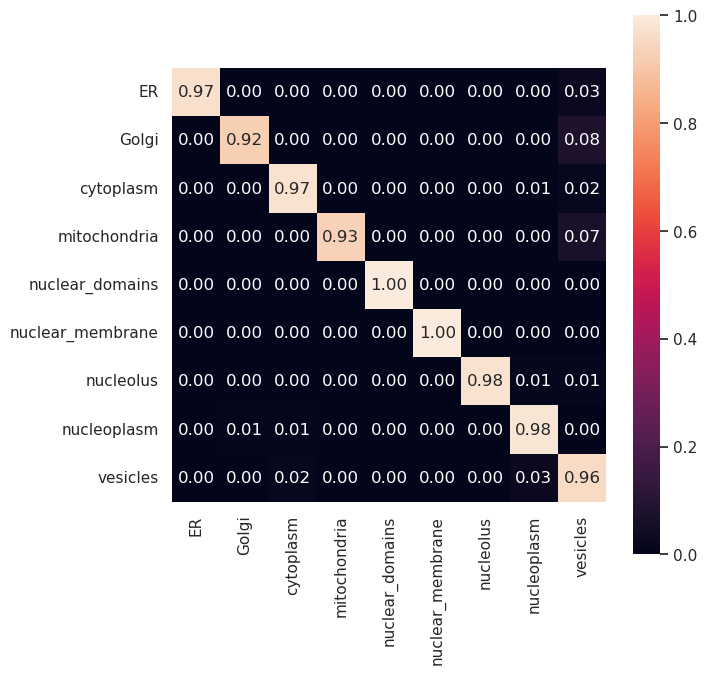

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [ ]:
other = true_localizations == 'other'
X_test = output_cytoself_embeds[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [ ]:
y_predict = clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9619047619047619


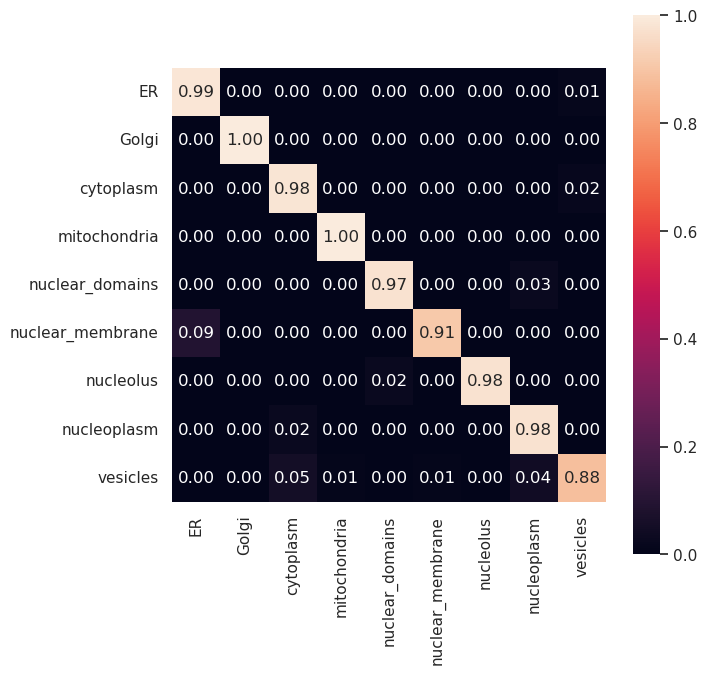

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [ ]:
y_predict_scores = clf.predict_proba(X_test)

In [ ]:
output_localization_classification_scores = [top_k_accuracy(y_test_indices, y_predict_scores, k=k) for k in range(1, 5)]

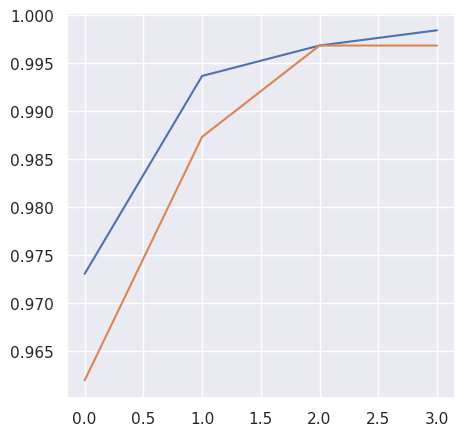

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(input_localization_classification_scores);
plt.plot(output_localization_classification_scores);

In [ ]:
print(input_localization_classification_scores[2])
print(output_localization_classification_scores[2])

0.9968253968253968
0.9968253968253968


## Autoencoder

In [ ]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer_autoencoder = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer_autoencoder.fit(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
from joblib import dump
from joblib import load

dump(reducer_autoencoder, join(datapath,'autoencoder_umap_model.joblib'))

# reducer = load(join(datapath,'autoencoder_umap_model.joblib'))

['/home/ec2-user/cytoself-data/results/autoencoder_umap_model.joblib']

In [ ]:
reduced_autoencoder_latent = reducer_autoencoder.transform(input_autoencoder_embeds.reshape(input_autoencoder_embeds.shape[0], -1))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

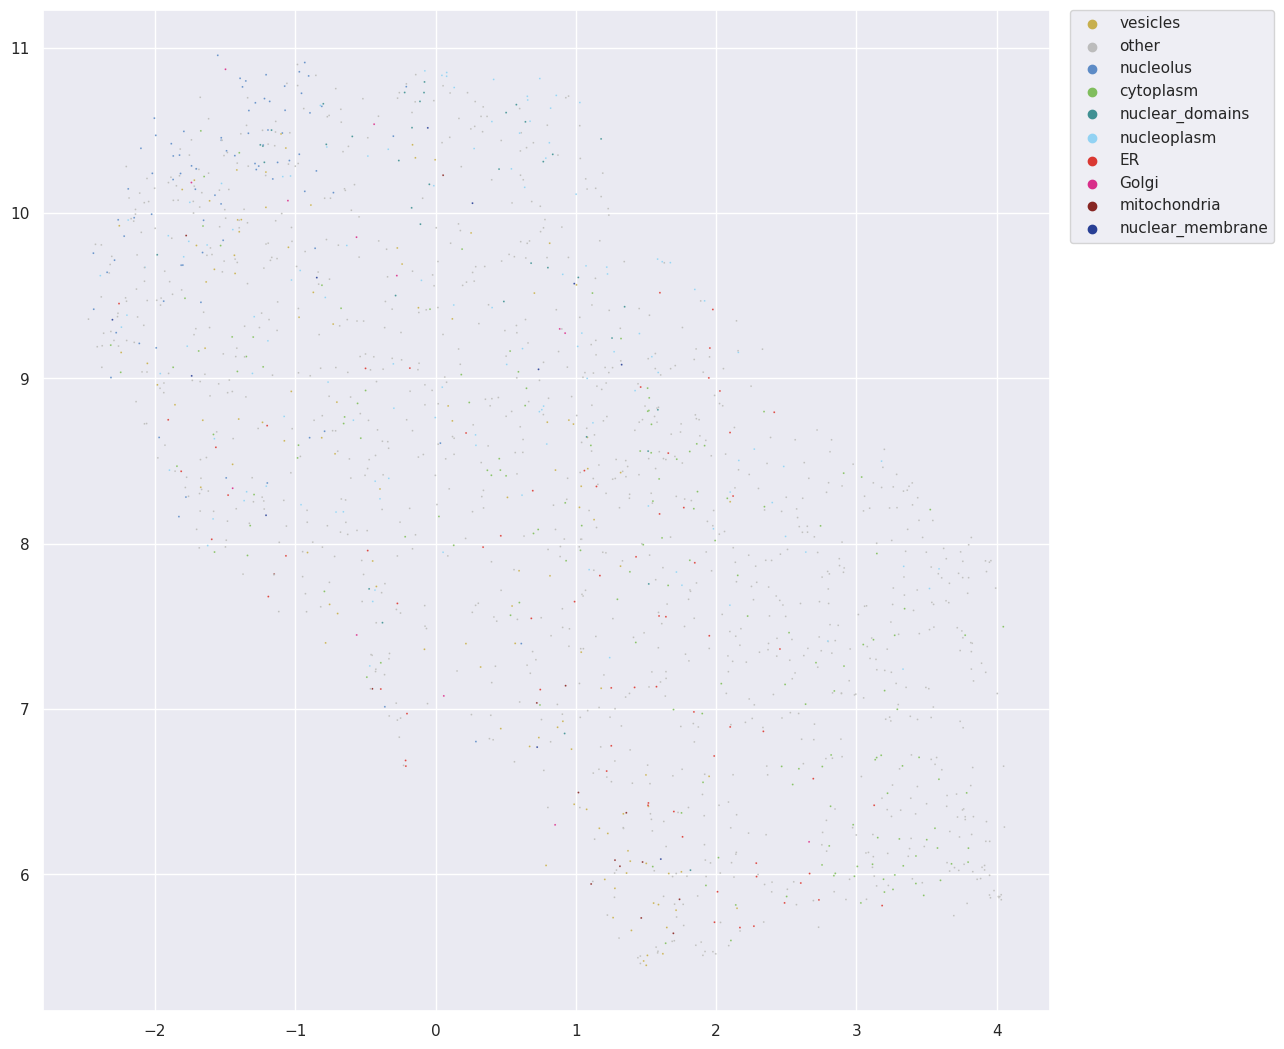

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_autoencoder_latent[:, 0], y=reduced_autoencoder_latent[:, 1], hue=true_localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);